<h1> In this notebook, we will implement a neural network that regresses volume against segmentation + depth map </h1>

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/root/alok/github/cv_research/alok')

import glob
import json
import os
import numpy as np
from PIL import Image

import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.backend import tf as ktf

from matplotlib import pyplot as plt
from matplotlib import cm
from biomass_utils.points_of_interest import get_point_cloud

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0"
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named biomass_utils.points_of_interest

In [3]:
# Get data ready

data_path_base = '/root/data/blender_v3'
image_dir = '{}/{}'.format(data_path_base, 'stereo_images')
depth_map_dir = '{}/{}'.format(data_path_base, 'depth_map')
segmentation_dir = '{}/{}'.format(data_path_base, 'mask')
annotation_dir = '{}/{}'.format(data_path_base, 'annotations')

number_key = lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1])
side_key = lambda x: os.path.splitext(os.path.basename(x))[0].split('_')[0]
all_image_paths = sorted(glob.glob('{}/*.png'.format(image_dir)), key=number_key)
image_paths = [p for p in all_image_paths if side_key(p) == 'left'] # we are working with left frame only
all_segmentation_paths = sorted(glob.glob('{}/*.npy'.format(segmentation_dir)), key=number_key)
segmentation_paths = [p for p in all_segmentation_paths if side_key(p) == 'left'] # we are working with left frame only
depth_map_paths = sorted(glob.glob('{}/*.npy'.format(depth_map_dir)), key=number_key)
annotation_paths = sorted(glob.glob('{}/*.json'.format(annotation_dir)), key=number_key) 
complete_data_list = zip(image_paths, segmentation_paths, depth_map_paths, annotation_paths)


TRAINING_SIZE = 500
train_data_list = [v for i, v in enumerate(complete_data_list) if i < TRAINING_SIZE]
test_data_list = [v for i, v in enumerate(complete_data_list) if i > TRAINING_SIZE]


In [2]:
sm = cm.ScalarMappable(cmap='hot')
sm.set_clim(vmin=0, vmax=20)

def convert_to_gradient_image(image_array, segmentation_mask, depth_map, annotation):    
    projected_depth_map = get_point_cloud(depth_map, annotation['focal_length'], 
                                          annotation['sensor_height'], 
                                          annotation['sensor_width'])[:,:,1]
    cleaned_depth_map = segmentation_mask * projected_depth_map
    rgb_depth_map = sm.to_rgba(cleaned_depth_map, bytes=True)[:,:,:3]
    image_array = image_array
    image_array = np.dstack([image_array, np.ones((image_array.shape[0], image_array.shape[1], 1))*255]).astype('uint8')
    rgb_depth_map = np.dstack([rgb_depth_map, np.ones((rgb_depth_map.shape[0], rgb_depth_map.shape[1], 1))*170]).astype('uint8')
    composite_image = Image.alpha_composite(Image.fromarray(image_array), Image.fromarray(rgb_depth_map))
    composite_image = composite_image * np.dstack([segmentation_mask, segmentation_mask, segmentation_mask, segmentation_mask])
    composite_image = composite_image[:,:,:3]
    return Image.fromarray(composite_image).resize((224, 224))
    
        


In [3]:
idx = 29
a = convert_to_gradient_image(np.array(Image.open(image_paths[idx]))[:,:,:3],
                                 np.load(segmentation_paths[idx]),
                                 np.load(depth_map_paths[idx]).T, 
                                 json.load(open(annotation_paths[idx], 'rb')))


NameError: name 'image_paths' is not defined

In [5]:
def generator(data_list, steps_per_epoch, BATCH_SIZE, INPUT_SHAPE):
    i = 0
    while True:
        x_batch = np.empty((BATCH_SIZE, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]))
        y_batch = np.empty((BATCH_SIZE, 1))
        for (ind, j) in enumerate(range(i*BATCH_SIZE, min((i+1)*BATCH_SIZE, len(data_list)))):
            image_array = np.array(Image.open(data_list[j][0]))[:,:,:3]
            segmentation_mask = np.load(data_list[j][1])
            depth_map = np.load(data_list[j][2]).T
            annotation = json.load(open(data_list[j][3], 'rb'))
            four_channel_input = convert_to_gradient_image(image_array, segmentation_mask, depth_map, annotation)
            x_batch[ind, ...] = four_channel_input
            y_batch[ind] = annotation['volume']
            print(data_list[j])
            
        i += 1
        if i >= steps_per_epoch:
            i = 0
        yield x_batch, y_batch

In [6]:
# Generate a model with all layers (with top)
vgg16 = VGG16(weights=None, include_top=True)

#Add a layer where input is the output of the  second last layer 
x = Dense(1, name='predictions')(vgg16.layers[-2].output)

#Then create the corresponding model 
model = Model(input=vgg16.input, output=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
  


In [7]:
optimizer = keras.optimizers.adam(lr=0.0001, decay=0.1)
model.compile(loss='mean_absolute_error',
              optimizer=optimizer,
              metrics=['accuracy'])

In [8]:
BATCH_SIZE = 25
steps_per_epoch = int(len(train_data_list)/BATCH_SIZE)
gen = generator(train_data_list, steps_per_epoch, BATCH_SIZE, (224, 224, 3))

In [9]:
model.fit_generator(gen, steps_per_epoch=steps_per_epoch, epochs=100, verbose=True)

Epoch 1/100
('/root/data/blender_v3/stereo_images/left_0.png', '/root/data/blender_v3/mask/left_0.npy', '/root/data/blender_v3/depth_map/depth_map_0.npy', '/root/data/blender_v3/annotations/annot_0.json')
('/root/data/blender_v3/stereo_images/left_1.png', '/root/data/blender_v3/mask/left_1.npy', '/root/data/blender_v3/depth_map/depth_map_1.npy', '/root/data/blender_v3/annotations/annot_1.json')
('/root/data/blender_v3/stereo_images/left_2.png', '/root/data/blender_v3/mask/left_2.npy', '/root/data/blender_v3/depth_map/depth_map_2.npy', '/root/data/blender_v3/annotations/annot_2.json')
('/root/data/blender_v3/stereo_images/left_3.png', '/root/data/blender_v3/mask/left_3.npy', '/root/data/blender_v3/depth_map/depth_map_3.npy', '/root/data/blender_v3/annotations/annot_3.json')
('/root/data/blender_v3/stereo_images/left_4.png', '/root/data/blender_v3/mask/left_4.npy', '/root/data/blender_v3/depth_map/depth_map_4.npy', '/root/data/blender_v3/annotations/annot_4.json')
('/root/data/blender_v3

('/root/data/blender_v3/stereo_images/left_41.png', '/root/data/blender_v3/mask/left_41.npy', '/root/data/blender_v3/depth_map/depth_map_41.npy', '/root/data/blender_v3/annotations/annot_41.json')
('/root/data/blender_v3/stereo_images/left_42.png', '/root/data/blender_v3/mask/left_42.npy', '/root/data/blender_v3/depth_map/depth_map_42.npy', '/root/data/blender_v3/annotations/annot_42.json')
('/root/data/blender_v3/stereo_images/left_43.png', '/root/data/blender_v3/mask/left_43.npy', '/root/data/blender_v3/depth_map/depth_map_43.npy', '/root/data/blender_v3/annotations/annot_43.json')
('/root/data/blender_v3/stereo_images/left_44.png', '/root/data/blender_v3/mask/left_44.npy', '/root/data/blender_v3/depth_map/depth_map_44.npy', '/root/data/blender_v3/annotations/annot_44.json')
('/root/data/blender_v3/stereo_images/left_45.png', '/root/data/blender_v3/mask/left_45.npy', '/root/data/blender_v3/depth_map/depth_map_45.npy', '/root/data/blender_v3/annotations/annot_45.json')
('/root/data/bl

('/root/data/blender_v3/stereo_images/left_82.png', '/root/data/blender_v3/mask/left_82.npy', '/root/data/blender_v3/depth_map/depth_map_82.npy', '/root/data/blender_v3/annotations/annot_82.json')
('/root/data/blender_v3/stereo_images/left_83.png', '/root/data/blender_v3/mask/left_83.npy', '/root/data/blender_v3/depth_map/depth_map_83.npy', '/root/data/blender_v3/annotations/annot_83.json')
('/root/data/blender_v3/stereo_images/left_84.png', '/root/data/blender_v3/mask/left_84.npy', '/root/data/blender_v3/depth_map/depth_map_84.npy', '/root/data/blender_v3/annotations/annot_84.json')
('/root/data/blender_v3/stereo_images/left_85.png', '/root/data/blender_v3/mask/left_85.npy', '/root/data/blender_v3/depth_map/depth_map_85.npy', '/root/data/blender_v3/annotations/annot_85.json')
('/root/data/blender_v3/stereo_images/left_86.png', '/root/data/blender_v3/mask/left_86.npy', '/root/data/blender_v3/depth_map/depth_map_86.npy', '/root/data/blender_v3/annotations/annot_86.json')
('/root/data/bl

('/root/data/blender_v3/stereo_images/left_123.png', '/root/data/blender_v3/mask/left_123.npy', '/root/data/blender_v3/depth_map/depth_map_123.npy', '/root/data/blender_v3/annotations/annot_123.json')
('/root/data/blender_v3/stereo_images/left_124.png', '/root/data/blender_v3/mask/left_124.npy', '/root/data/blender_v3/depth_map/depth_map_124.npy', '/root/data/blender_v3/annotations/annot_124.json')
('/root/data/blender_v3/stereo_images/left_125.png', '/root/data/blender_v3/mask/left_125.npy', '/root/data/blender_v3/depth_map/depth_map_125.npy', '/root/data/blender_v3/annotations/annot_125.json')
('/root/data/blender_v3/stereo_images/left_126.png', '/root/data/blender_v3/mask/left_126.npy', '/root/data/blender_v3/depth_map/depth_map_126.npy', '/root/data/blender_v3/annotations/annot_126.json')
 5/20 [======>.......................] - ETA: 54s - loss: 3245.3815 - acc: 0.0000e+00('/root/data/blender_v3/stereo_images/left_127.png', '/root/data/blender_v3/mask/left_127.npy', '/root/data/ble

('/root/data/blender_v3/stereo_images/left_163.png', '/root/data/blender_v3/mask/left_163.npy', '/root/data/blender_v3/depth_map/depth_map_163.npy', '/root/data/blender_v3/annotations/annot_163.json')
('/root/data/blender_v3/stereo_images/left_164.png', '/root/data/blender_v3/mask/left_164.npy', '/root/data/blender_v3/depth_map/depth_map_164.npy', '/root/data/blender_v3/annotations/annot_164.json')
('/root/data/blender_v3/stereo_images/left_165.png', '/root/data/blender_v3/mask/left_165.npy', '/root/data/blender_v3/depth_map/depth_map_165.npy', '/root/data/blender_v3/annotations/annot_165.json')
('/root/data/blender_v3/stereo_images/left_166.png', '/root/data/blender_v3/mask/left_166.npy', '/root/data/blender_v3/depth_map/depth_map_166.npy', '/root/data/blender_v3/annotations/annot_166.json')
('/root/data/blender_v3/stereo_images/left_167.png', '/root/data/blender_v3/mask/left_167.npy', '/root/data/blender_v3/depth_map/depth_map_167.npy', '/root/data/blender_v3/annotations/annot_167.js

('/root/data/blender_v3/stereo_images/left_203.png', '/root/data/blender_v3/mask/left_203.npy', '/root/data/blender_v3/depth_map/depth_map_203.npy', '/root/data/blender_v3/annotations/annot_203.json')
('/root/data/blender_v3/stereo_images/left_204.png', '/root/data/blender_v3/mask/left_204.npy', '/root/data/blender_v3/depth_map/depth_map_204.npy', '/root/data/blender_v3/annotations/annot_204.json')
('/root/data/blender_v3/stereo_images/left_205.png', '/root/data/blender_v3/mask/left_205.npy', '/root/data/blender_v3/depth_map/depth_map_205.npy', '/root/data/blender_v3/annotations/annot_205.json')
('/root/data/blender_v3/stereo_images/left_206.png', '/root/data/blender_v3/mask/left_206.npy', '/root/data/blender_v3/depth_map/depth_map_206.npy', '/root/data/blender_v3/annotations/annot_206.json')
('/root/data/blender_v3/stereo_images/left_207.png', '/root/data/blender_v3/mask/left_207.npy', '/root/data/blender_v3/depth_map/depth_map_207.npy', '/root/data/blender_v3/annotations/annot_207.js

('/root/data/blender_v3/stereo_images/left_244.png', '/root/data/blender_v3/mask/left_244.npy', '/root/data/blender_v3/depth_map/depth_map_244.npy', '/root/data/blender_v3/annotations/annot_244.json')
('/root/data/blender_v3/stereo_images/left_245.png', '/root/data/blender_v3/mask/left_245.npy', '/root/data/blender_v3/depth_map/depth_map_245.npy', '/root/data/blender_v3/annotations/annot_245.json')
('/root/data/blender_v3/stereo_images/left_246.png', '/root/data/blender_v3/mask/left_246.npy', '/root/data/blender_v3/depth_map/depth_map_246.npy', '/root/data/blender_v3/annotations/annot_246.json')
('/root/data/blender_v3/stereo_images/left_247.png', '/root/data/blender_v3/mask/left_247.npy', '/root/data/blender_v3/depth_map/depth_map_247.npy', '/root/data/blender_v3/annotations/annot_247.json')
('/root/data/blender_v3/stereo_images/left_248.png', '/root/data/blender_v3/mask/left_248.npy', '/root/data/blender_v3/depth_map/depth_map_248.npy', '/root/data/blender_v3/annotations/annot_248.js

('/root/data/blender_v3/stereo_images/left_284.png', '/root/data/blender_v3/mask/left_284.npy', '/root/data/blender_v3/depth_map/depth_map_284.npy', '/root/data/blender_v3/annotations/annot_284.json')
('/root/data/blender_v3/stereo_images/left_285.png', '/root/data/blender_v3/mask/left_285.npy', '/root/data/blender_v3/depth_map/depth_map_285.npy', '/root/data/blender_v3/annotations/annot_285.json')
('/root/data/blender_v3/stereo_images/left_286.png', '/root/data/blender_v3/mask/left_286.npy', '/root/data/blender_v3/depth_map/depth_map_286.npy', '/root/data/blender_v3/annotations/annot_286.json')
('/root/data/blender_v3/stereo_images/left_287.png', '/root/data/blender_v3/mask/left_287.npy', '/root/data/blender_v3/depth_map/depth_map_287.npy', '/root/data/blender_v3/annotations/annot_287.json')
('/root/data/blender_v3/stereo_images/left_288.png', '/root/data/blender_v3/mask/left_288.npy', '/root/data/blender_v3/depth_map/depth_map_288.npy', '/root/data/blender_v3/annotations/annot_288.js

('/root/data/blender_v3/stereo_images/left_325.png', '/root/data/blender_v3/mask/left_325.npy', '/root/data/blender_v3/depth_map/depth_map_325.npy', '/root/data/blender_v3/annotations/annot_325.json')
('/root/data/blender_v3/stereo_images/left_326.png', '/root/data/blender_v3/mask/left_326.npy', '/root/data/blender_v3/depth_map/depth_map_326.npy', '/root/data/blender_v3/annotations/annot_326.json')
13/20 [==================>...........] - ETA: 24s - loss: 2210.8061 - acc: 0.0000e+00('/root/data/blender_v3/stereo_images/left_327.png', '/root/data/blender_v3/mask/left_327.npy', '/root/data/blender_v3/depth_map/depth_map_327.npy', '/root/data/blender_v3/annotations/annot_327.json')
('/root/data/blender_v3/stereo_images/left_328.png', '/root/data/blender_v3/mask/left_328.npy', '/root/data/blender_v3/depth_map/depth_map_328.npy', '/root/data/blender_v3/annotations/annot_328.json')
('/root/data/blender_v3/stereo_images/left_329.png', '/root/data/blender_v3/mask/left_329.npy', '/root/data/ble

('/root/data/blender_v3/stereo_images/left_365.png', '/root/data/blender_v3/mask/left_365.npy', '/root/data/blender_v3/depth_map/depth_map_365.npy', '/root/data/blender_v3/annotations/annot_365.json')
('/root/data/blender_v3/stereo_images/left_366.png', '/root/data/blender_v3/mask/left_366.npy', '/root/data/blender_v3/depth_map/depth_map_366.npy', '/root/data/blender_v3/annotations/annot_366.json')
('/root/data/blender_v3/stereo_images/left_367.png', '/root/data/blender_v3/mask/left_367.npy', '/root/data/blender_v3/depth_map/depth_map_367.npy', '/root/data/blender_v3/annotations/annot_367.json')
('/root/data/blender_v3/stereo_images/left_368.png', '/root/data/blender_v3/mask/left_368.npy', '/root/data/blender_v3/depth_map/depth_map_368.npy', '/root/data/blender_v3/annotations/annot_368.json')
('/root/data/blender_v3/stereo_images/left_369.png', '/root/data/blender_v3/mask/left_369.npy', '/root/data/blender_v3/depth_map/depth_map_369.npy', '/root/data/blender_v3/annotations/annot_369.js

('/root/data/blender_v3/stereo_images/left_405.png', '/root/data/blender_v3/mask/left_405.npy', '/root/data/blender_v3/depth_map/depth_map_405.npy', '/root/data/blender_v3/annotations/annot_405.json')
('/root/data/blender_v3/stereo_images/left_406.png', '/root/data/blender_v3/mask/left_406.npy', '/root/data/blender_v3/depth_map/depth_map_406.npy', '/root/data/blender_v3/annotations/annot_406.json')
('/root/data/blender_v3/stereo_images/left_407.png', '/root/data/blender_v3/mask/left_407.npy', '/root/data/blender_v3/depth_map/depth_map_407.npy', '/root/data/blender_v3/annotations/annot_407.json')
('/root/data/blender_v3/stereo_images/left_408.png', '/root/data/blender_v3/mask/left_408.npy', '/root/data/blender_v3/depth_map/depth_map_408.npy', '/root/data/blender_v3/annotations/annot_408.json')
('/root/data/blender_v3/stereo_images/left_409.png', '/root/data/blender_v3/mask/left_409.npy', '/root/data/blender_v3/depth_map/depth_map_409.npy', '/root/data/blender_v3/annotations/annot_409.js

('/root/data/blender_v3/stereo_images/left_446.png', '/root/data/blender_v3/mask/left_446.npy', '/root/data/blender_v3/depth_map/depth_map_446.npy', '/root/data/blender_v3/annotations/annot_446.json')
('/root/data/blender_v3/stereo_images/left_447.png', '/root/data/blender_v3/mask/left_447.npy', '/root/data/blender_v3/depth_map/depth_map_447.npy', '/root/data/blender_v3/annotations/annot_447.json')
('/root/data/blender_v3/stereo_images/left_448.png', '/root/data/blender_v3/mask/left_448.npy', '/root/data/blender_v3/depth_map/depth_map_448.npy', '/root/data/blender_v3/annotations/annot_448.json')
('/root/data/blender_v3/stereo_images/left_449.png', '/root/data/blender_v3/mask/left_449.npy', '/root/data/blender_v3/depth_map/depth_map_449.npy', '/root/data/blender_v3/annotations/annot_449.json')
('/root/data/blender_v3/stereo_images/left_450.png', '/root/data/blender_v3/mask/left_450.npy', '/root/data/blender_v3/depth_map/depth_map_450.npy', '/root/data/blender_v3/annotations/annot_450.js

('/root/data/blender_v3/stereo_images/left_486.png', '/root/data/blender_v3/mask/left_486.npy', '/root/data/blender_v3/depth_map/depth_map_486.npy', '/root/data/blender_v3/annotations/annot_486.json')
('/root/data/blender_v3/stereo_images/left_487.png', '/root/data/blender_v3/mask/left_487.npy', '/root/data/blender_v3/depth_map/depth_map_487.npy', '/root/data/blender_v3/annotations/annot_487.json')
('/root/data/blender_v3/stereo_images/left_488.png', '/root/data/blender_v3/mask/left_488.npy', '/root/data/blender_v3/depth_map/depth_map_488.npy', '/root/data/blender_v3/annotations/annot_488.json')
('/root/data/blender_v3/stereo_images/left_489.png', '/root/data/blender_v3/mask/left_489.npy', '/root/data/blender_v3/depth_map/depth_map_489.npy', '/root/data/blender_v3/annotations/annot_489.json')
('/root/data/blender_v3/stereo_images/left_490.png', '/root/data/blender_v3/mask/left_490.npy', '/root/data/blender_v3/depth_map/depth_map_490.npy', '/root/data/blender_v3/annotations/annot_490.js

KeyboardInterrupt: 

In [1]:
eval_gen = generator(test_data_list, np.inf, BATCH_SIZE, (224, 224, 3))
scores = model.evaluate_generator(eval_gen, 50)

NameError: name 'generator' is not defined

In [28]:
eval_gen = generator(test_data_list, np.inf, BATCH_SIZE, (224, 224, 3))
predictions = model.predict_generator(eval_gen, 120)

In [29]:
ground_truth_values = np.array([])
for i in range(120*25):
    annotation = json.load(open(test_data_list[i][3], 'rb'))
    ground_truth_values = np.append(ground_truth_values, annotation['volume'])

In [30]:
(ground_truth_values.mean() - predictions[:,0].mean())/(ground_truth_values.mean())

0.015226438229773941

In [16]:
ground_truth_values

array([2068.00994581, 1983.57114122, 5667.58181159, ...,  543.67955969,
       7200.4383445 ,  786.05285821])

In [17]:
predictions[:,0]

array([2074.5874, 1821.5377, 5909.4644, ...,  659.0779, 6892.836 ,
        745.3722], dtype=float32)

In [18]:
ground_truth_values.mean()

3348.287045002889

In [19]:
ground_truth_values

array([2068.00994581, 1983.57114122, 5667.58181159, ...,  543.67955969,
       7200.4383445 ,  786.05285821])

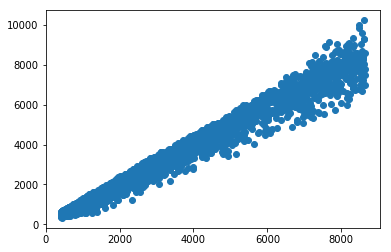

In [32]:
plt.scatter(ground_truth_values, predictions[:,0])

In [31]:
np.percentile((abs(ground_truth_values - predictions[:,0])/ground_truth_values), 95)

0.292572184149916

In [5]:
json.load(open(annotation_paths[0]))

{u'focal_length': 1.0,
 u'height': 20.76045918246681,
 u'interocular_distance': 0.6499999761581421,
 u'length': 103.80229591233405,
 u'sensor_height': 3.2,
 u'sensor_width': 1.8,
 u'unit': u'centimeter',
 u'unit_system': u'METRIC',
 u'volume': 4410.102564548064,
 u'width': 17.300382652055674}